[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ltzgUz_s1VOgYcSOmqqsknp1f5hCVgjI?usp=sharing)

# Problem description

In this Notebook we want to approximate the time-$h$ flow map of the simple harmonic oscillator. We want to do so, while preserving the symplectic nature of the flow map. The Hamiltonian of this system is
$$
H(p, q)=\frac{1}{2}(q^2+p^2),
$$
and the equations of motion write
$$
\begin{gathered}
\frac{d q}{d t}=\frac{\partial H}{\partial p}=p \\
\frac{d p}{d t}=-\frac{\partial H}{\partial q}=-q \\
\end{gathered}.
$$
We want to approximate the map $\phi^{0.1}_{X_H}:\mathbb{R}^2\to\mathbb{R}^2$.

# Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn.functional import tanh
from torch.func import jacrev,vmap
from scipy.integrate import solve_ivp
from torch.utils.data import DataLoader, Dataset, random_split
from IPython.display import display, Math

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10

# Defining the dynamics to approximate

In [3]:
def oscillator_hamiltonian(q, p):
    return 0.5*(q**2+p**2)

def harmonic_oscillator(t, y):
    q, p = y
    dq_dt = p
    dp_dt = -q
    return [dq_dt, dp_dt]

# Define a Symplectic Neural Network

To define a Symplectic Neural Network, we compose exact flows of very simple Hamiltonian systems. These systems have Hamiltonian either depending solely on the $q$ variable, or the $p$ variable. They are of the form
$$
H_q(q,p) = \boldsymbol{1}^\top \gamma(Aq+a),\,\,H_p(q,p)=\boldsymbol{1}^\top\gamma(Bp+b),
$$
where $\gamma=\log\circ \cosh$ so that $\gamma' = \tanh$.

In this way we get layers of the form
$$
(q,p)\mapsto \begin{pmatrix} q \\ p - h_iA_i^\top\sigma(A_iq+a_i) \end{pmatrix},\,\,(q,p)\mapsto \begin{pmatrix} q + h_iB_i^\top\sigma(B_ip+b_i)\\ p \end{pmatrix},
$$
with $\sigma(s)=\tanh(s)$.

In [4]:
class SymplecticBlock(nn.Module):
    def __init__(self, step_size = 1., d = 2, dtype = torch.float32):
        super().__init__()

        self.step_size = step_size

        self.A = nn.Parameter(torch.randn(d//2,d//2,dtype=dtype))
        self.a = nn.Parameter(torch.randn(d//2,dtype=dtype))

        self.B = nn.Parameter(torch.randn(d//2,d//2,dtype=dtype))
        self.b = nn.Parameter(torch.randn(d//2,dtype=dtype))

    def forward(self, q, p):

        inner_q = tanh(F.linear(input=q,weight=self.A,bias=self.a)) # sigma(Aq+a)
        p_new = p - torch.abs(self.step_size) * F.linear(inner_q,self.A.T) # p - h A^T sigma(Aq+a)

        inner_p = tanh(F.linear(input=p_new,weight=self.B,bias=self.b)) # sigma(Bp_new+b)
        q_new = q + torch.abs(self.step_size) * F.linear(inner_p,self.B.T) # q + h B^T sigma(Bp_new+b)

        return q_new, p_new

In [5]:
class SymplecticNetwork(nn.Module):
    def __init__(self, n_layers = 5, d = 2, dtype=torch.float32):
          super().__init__()

          assert np.mod(d,2)==0

          self.n_layers = n_layers
          self.d = d
          self.dtype = dtype

          self.step_sizes = nn.Parameter(torch.rand(n_layers, dtype=dtype))

          self.symplectic_blocks = nn.ModuleList([
              SymplecticBlock(
                  step_size=self.step_sizes[i],
                  d = self.d,
                  dtype=dtype) for i in range(n_layers) #We stack n_layers of the symplectic blocks
              ])

    def forward(self, y):

        q, p = y[:,:self.d//2], y[:,self.d//2:] #y has shape Batch Size x 4
        for i in range(self.n_layers):
          q, p = self.symplectic_blocks[i](q,p)

        output = torch.cat((q,p),dim=1)

        return output

In [6]:
def check_is_symplectic(model):
        #Checks if the model defines a symplectic map
      def map(y):
          return model(y.reshape(-1,model.d))

      ## Check if the network is symplectic
      y = torch.randn(1,model.d,dtype=model.dtype)
      jac = vmap(jacrev(map,argnums=0))(y)[0,0]
      id = torch.eye(model.d//2,dtype=model.dtype)
      zz = torch.zeros((model.d//2,model.d//2),dtype=model.dtype)
      row1 = torch.cat((zz,id),dim=1)
      row2 = torch.cat((-id,zz),dim=1)
      J = torch.cat((row1,row2),dim=0)
      display(Math(r"\mathcal{N}'(x)^T\mathbb{J}\mathcal{N}'(x):"))
      print((jac.T @ J @ jac).detach().cpu().numpy())
      print("Is the network symplectic? ",torch.allclose(jac.T @ J @ jac,J))

In [7]:
sympNet = SymplecticNetwork(n_layers = 5, d = 2, dtype=torch.float64)

In [8]:
check_is_symplectic(sympNet)

<IPython.core.display.Math object>

[[-4.65890678e-19  1.00000000e+00]
 [-1.00000000e+00 -2.74502699e-17]]
Is the network symplectic?  True


# Build the dataset

In [9]:
# Generate the dataset
def generate_harmonic_oscillator_data(num_samples=1000, step_size=0.1, dtype=torch.float64):
    x0 = np.random.rand(num_samples, 2) * 2 - 1  # Initial conditions sampled from [-1, 1]^2
    x1 = np.zeros_like(x0)

    # Integrate each initial condition using RK45 with high accuracy
    for i in range(num_samples):
        sol = solve_ivp(harmonic_oscillator, [0, step_size], x0[i], method='RK45', atol=1e-10, rtol=1e-10)
        x1[i] = sol.y[:, -1]  # Take the final value at t=step_size

    x0 = torch.tensor(x0, dtype=dtype)
    x1 = torch.tensor(x1, dtype=dtype)

    return x0, x1

class HarmonicOscillatorDataset(Dataset):
    def __init__(self, x0, x1):
        # Generate initial conditions
        self.x0 = x0
        self.x1 = x1

    def __len__(self):
        return len(self.x0)

    def __getitem__(self, idx):
        # Return a single sample (initial condition and updated point)
        return self.x0[idx], self.x1[idx]

dt = 0.1
x0, x1 = generate_harmonic_oscillator_data(dtype = torch.float32, step_size = dt)
dataset = HarmonicOscillatorDataset(x0, x1)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

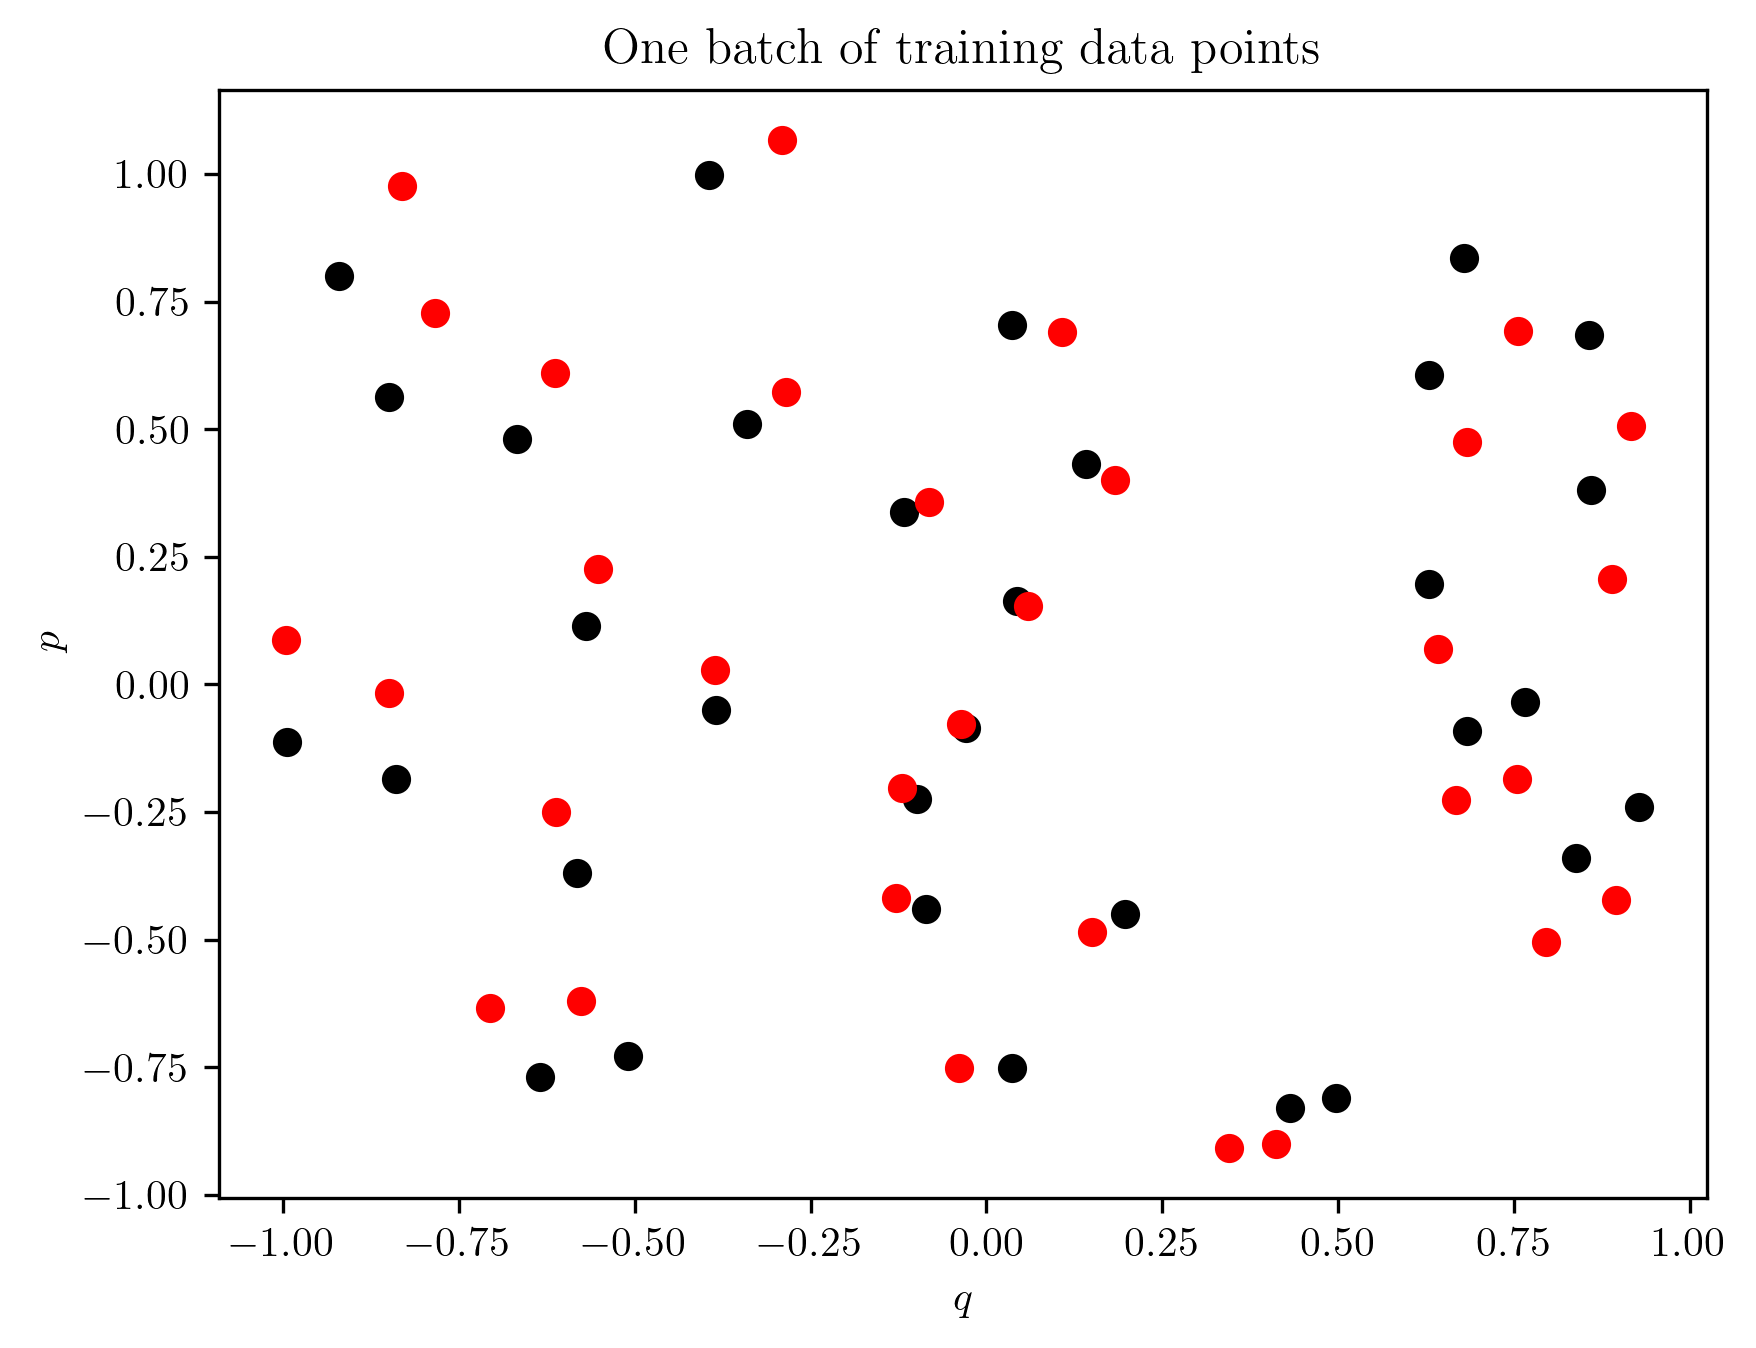

In [10]:
initial_cond, update = next(iter(train_loader))
plt.scatter(initial_cond[:,0].detach().numpy(),initial_cond[:,1].detach().numpy(),c='k')
plt.scatter(update[:,0].detach().numpy(),update[:,1].detach().numpy(),c='r')
plt.xlabel(r"$q$")
plt.ylabel(r"$p$")
plt.title("One batch of training data points")
plt.show();

# Train the network

In [11]:
model_symplectic = SymplecticNetwork(n_layers=5, dtype = torch.float32)
optimizer = torch.optim.Adam(model_symplectic.parameters(), lr=1e-2)
epochs = 300

loss_fn = nn.MSELoss()

# Training loop
for epoch in (pbar := tqdm(range(epochs),desc='Training progress')):
    for batch in train_loader:

        optimizer.zero_grad()

        x0, x1 = batch
        x1_pred = model_symplectic(x0)
        loss = loss_fn(x1_pred,x1)

        loss.backward()
        optimizer.step()
    pbar.set_description(f"Epoch {epoch+1}/{epochs}")
    pbar.set_postfix({"Loss": loss.item()})

Epoch 300/300: 100%|██████████| 300/300 [00:07<00:00, 37.59it/s, Loss=9.86e-7]


# Test the network

In [12]:
# Generate reference solution using RK45
def generate_reference_solution(x0, T=10, step_size=dt):
    sol = solve_ivp(harmonic_oscillator, [0, T], x0, method='RK45', atol=1e-10, rtol=1e-10)
    return sol.t, sol.y[0], sol.y[1]  # Returns time, q, p

# Predict solution with neural network
def generate_network_solution(model, x0, T=10, step_size=dt):
    steps = int(T / step_size)
    q_pred, p_pred = [x0[0]], [x0[1]]

    with torch.no_grad():
        x = x0.clone().detach().unsqueeze(0)  # Make x0 a batch of size 1
        for _ in range(steps):
            x = model(x)  # Predict the next step
            q_pred.append(x[0, 0].item())
            p_pred.append(x[0, 1].item())

    time = np.linspace(0, T, steps + 1)
    return time, np.array(q_pred), np.array(p_pred)

def generate_plots(ic,network,T=10,label="symplectic"):
  step_size = dt
  network.eval();

  ic_numpy = ic.detach().numpy()
  print("Selected initial condition : ",ic_numpy)

  # Generate reference and predicted solutions
  t_ref, q_ref, p_ref = generate_reference_solution(ic_numpy, T, step_size)
  t_pred, q_pred, p_pred = generate_network_solution(network, ic, T, step_size)

  # Compute energies
  energy_ref = oscillator_hamiltonian(q_ref, p_ref)
  energy_pred = oscillator_hamiltonian(q_pred, p_pred)

  # Plotting
  fig, axs = plt.subplots(1, 2)
  plt.rcParams["figure.figsize"] = (4.5,1) #Orbits SimpleHO

  colors_back = ["k","b"]
  colors_front = ["c","g"]

  '''# Subplot 1: Time evolution of q and p
  axs[0].plot(t_ref, q_ref, label=r'$q$ reference', linestyle='-', color=colors_back[0])
  axs[0].plot(t_pred, q_pred, label=r'$q$ predicted', linestyle='--', color=colors_front[0])
  axs[0].plot(t_ref, p_ref, label=r'$p$ reference', linestyle='-', color=colors_back[1])
  axs[0].plot(t_pred, p_pred, label=r'$p$ predicted', linestyle='--', color=colors_front[1])
  axs[0].set_xlabel("Time")
  #axs[0].set_ylabel(r"Values of $q$ and $p$")
  axs[0].legend()
  axs[0].set_title(r"Time Evolution of $q$ and $p$")'''

  # Subplot 2: Phase space plot (p vs q)
  axs[0].plot(q_ref, p_ref, label='Reference', linestyle='-', color=colors_back[0])
  axs[0].plot(q_pred, p_pred, label='Predicted', linestyle='--', color=colors_front[0])
  axs[0].set_xlabel(r"$q$")
  axs[0].set_ylabel(r"$p$")
  axs[0].set_xticks([-1.0,1.0])
  axs[0].set_yticks([-1.0,1.0])
  
  #axs[0].legend()
  axs[0].set_aspect('equal', adjustable='box')
  axs[0].set_title(r"Phase Space ($p$ vs $q$)")

  # Subplot 3: Energy comparison
  axs[1].plot(t_pred, energy_pred, label='Energy predicted', linestyle='--', color=colors_front[0])
  axs[1].plot(t_ref, energy_ref, label='Energy reference', linestyle='-', color=colors_back[0])
  axs[1].set_xlabel(r"$t$")
  #axs[1].set_ylabel("Energy")
  #axs[1].legend()
  axs[1].set_title("Energy Behaviour")

  #plt.suptitle(fr"Plots for $T$={T}")
  lines, labels = axs[0].get_legend_handles_labels()  # Get labels from the first subplot
  fig.legend(lines, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.65))  # Shared legend at the top

  

  plt.savefig(f"resultsT={T}_{label}.pdf",bbox_inches="tight")

  plt.show()


In [13]:
'''ic, _ = next(iter(test_loader)) #pick a test initial condition
ic = ic[0]'''
ic = torch.tensor([1.0, 0.])

Selected initial condition :  [1. 0.]


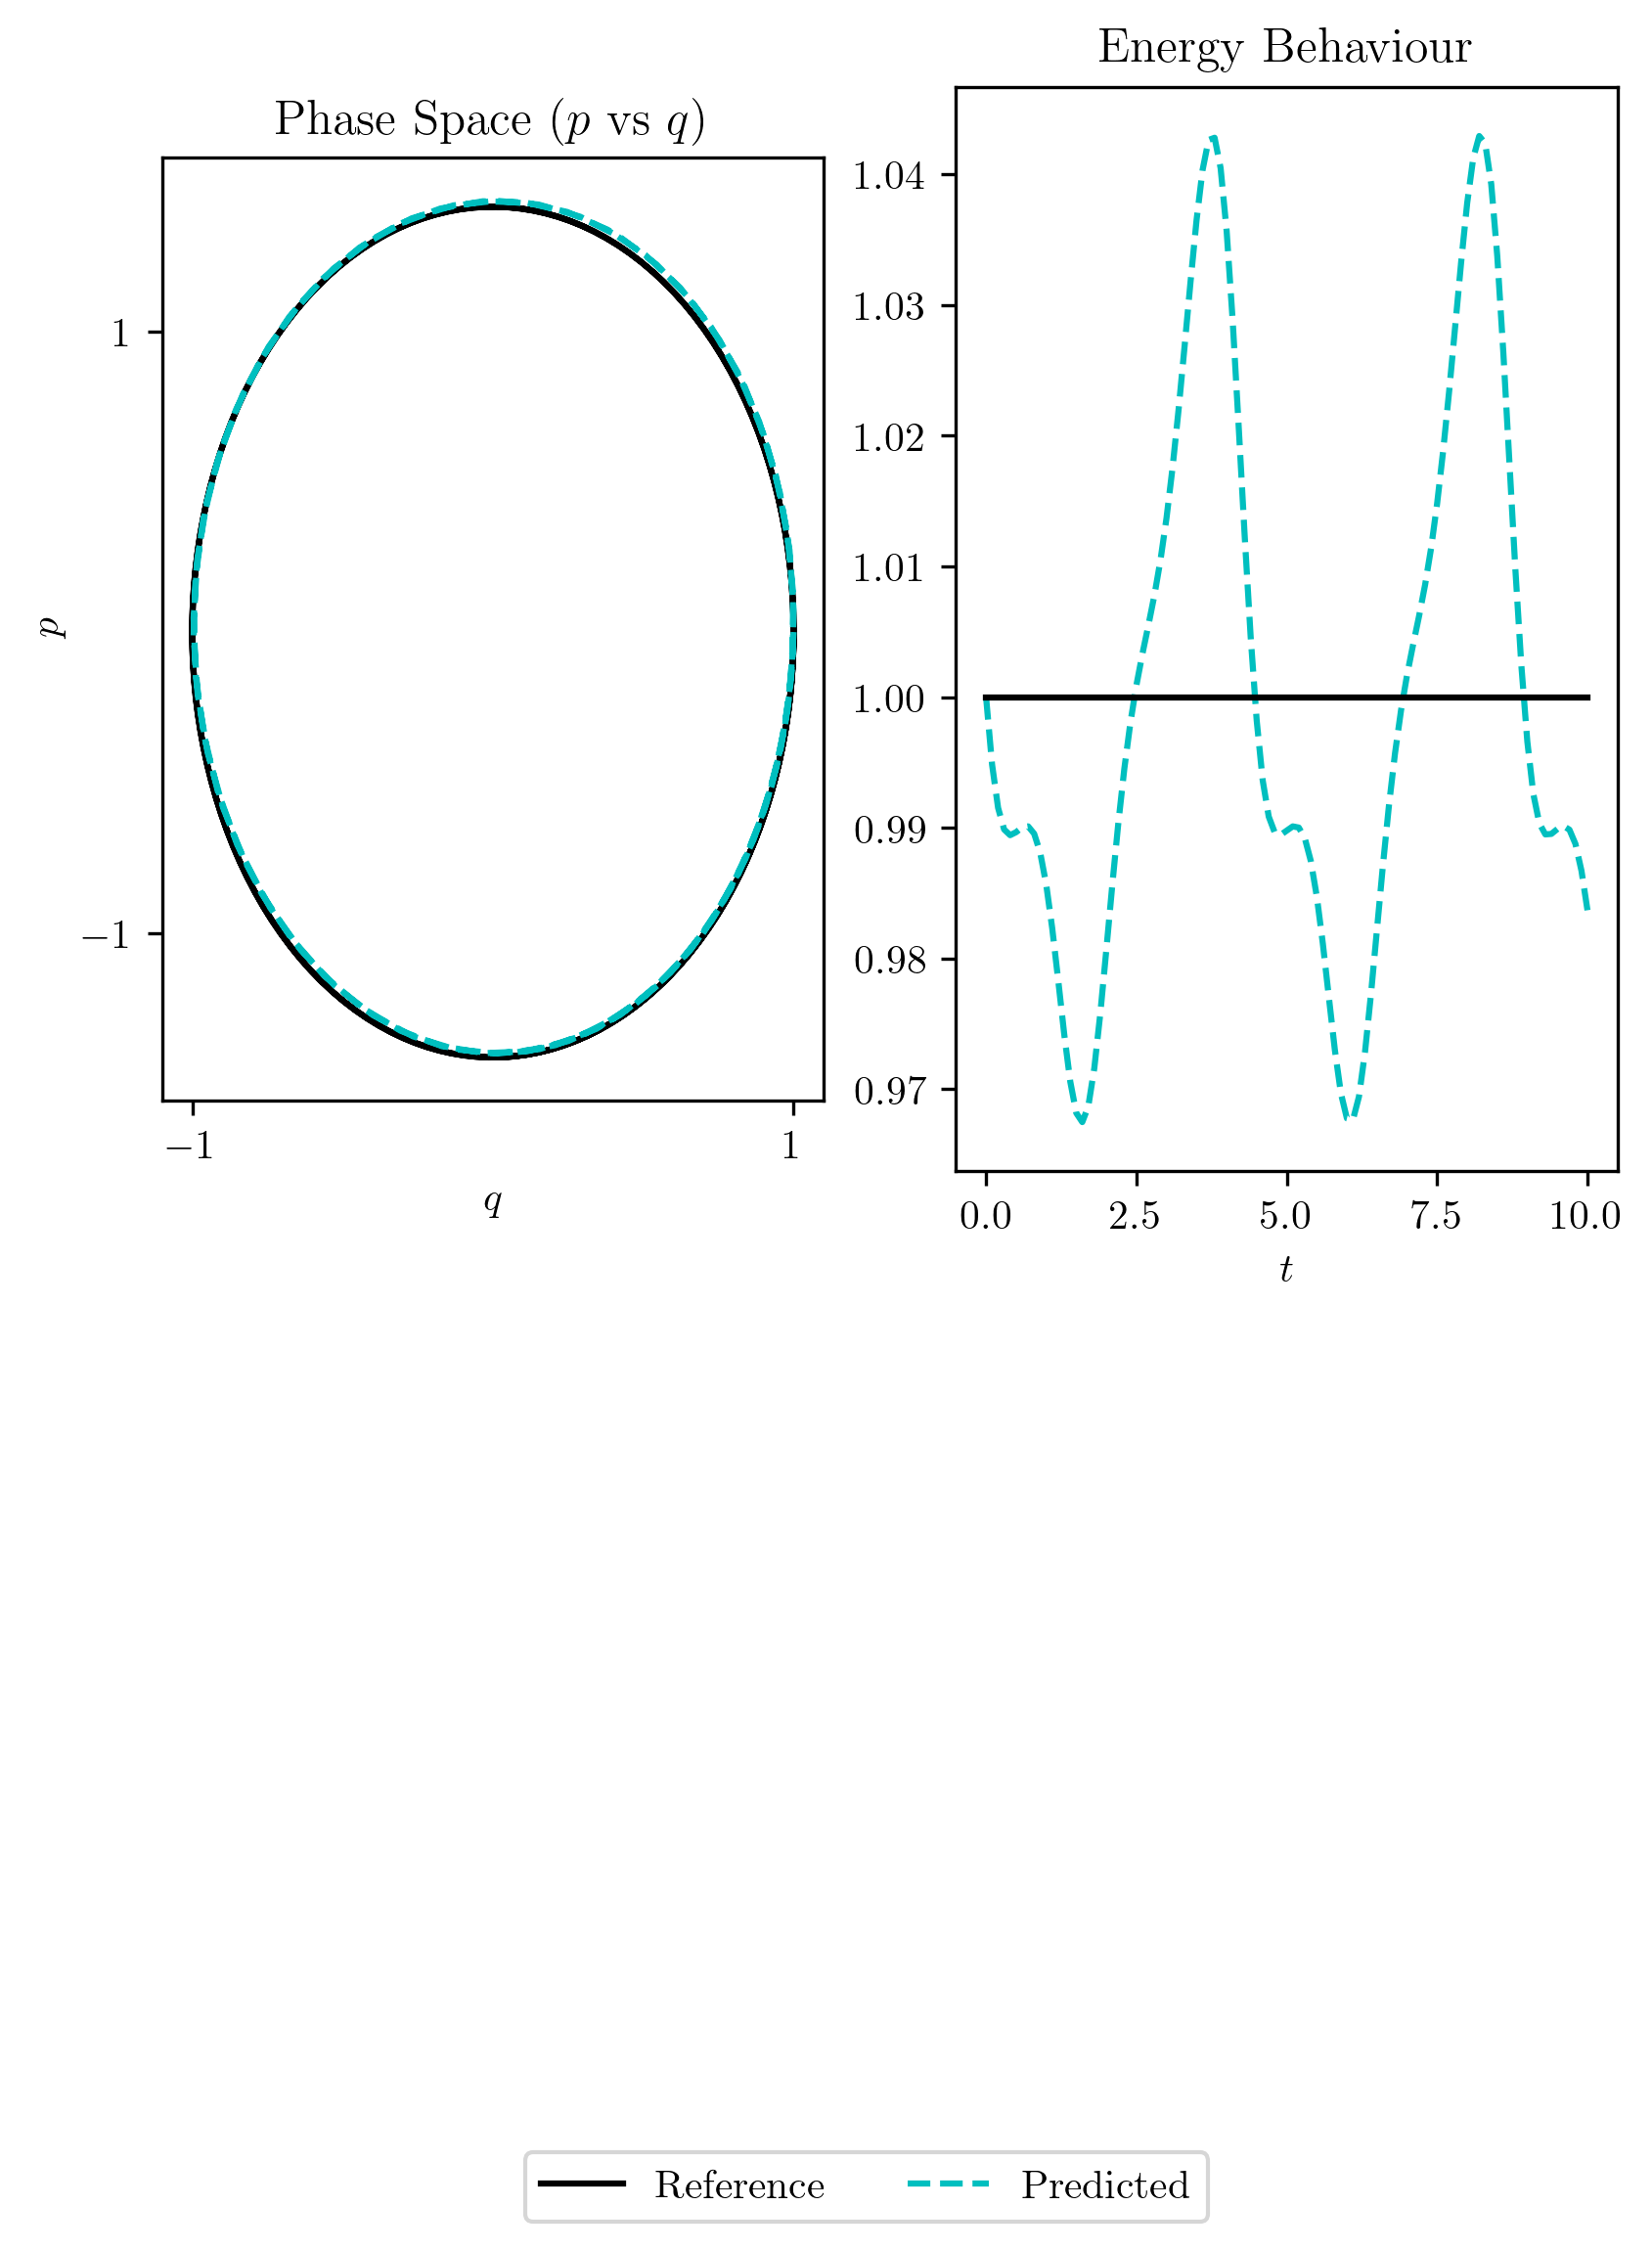

Selected initial condition :  [1. 0.]


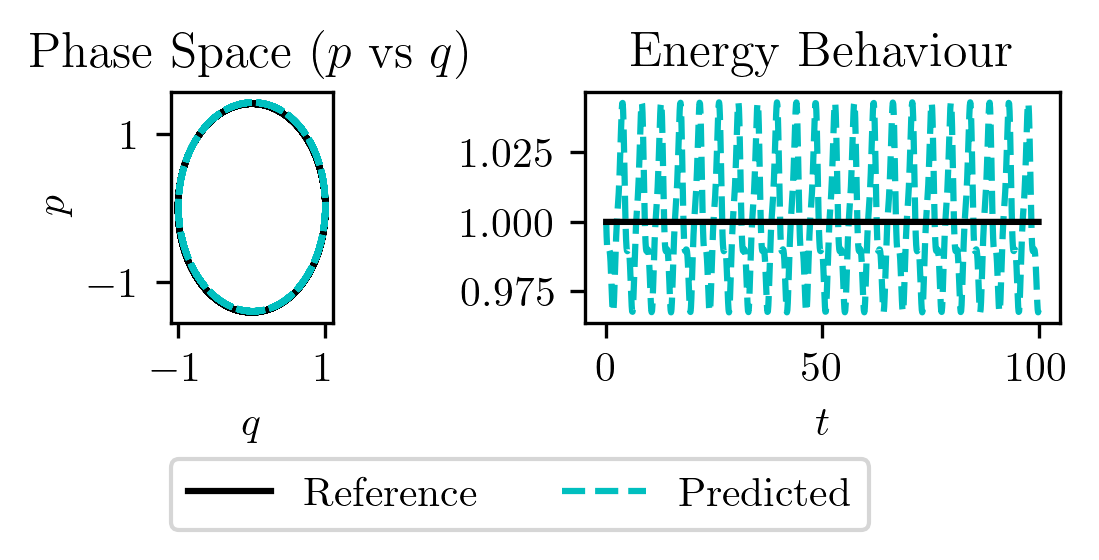

In [14]:
generate_plots(ic,model_symplectic,T=10,label="symplectic")
generate_plots(ic,model_symplectic,T=100,label="symplectic")

# Train and test a non-symplectic network

In [15]:
class Block(nn.Module):
    def __init__(self, step_size = 1., d = 2, dtype = torch.float32):
        super().__init__()

        self.step_size = step_size

        self.linearA = nn.Linear(d,d,dtype=dtype)# it is like x-> Ax + a
        self.linearB = nn.Linear(d,d,dtype=dtype,bias=False) # it is like x-> Bx

    def forward(self, x):
        return x + torch.abs(self.step_size) * self.linearB(tanh(self.linearA(x))) # x + h * B * sigma(Ax+a)

In [16]:
class Network(nn.Module):
    def __init__(self, n_layers = 5, d = 2, dtype=torch.float32):
          super().__init__()

          assert np.mod(d,2)==0

          self.n_layers = n_layers
          self.d = d
          self.dtype = dtype

          self.step_sizes = nn.Parameter(torch.rand(n_layers, dtype=dtype))

          self.blocks = nn.ModuleList([
              Block(
                  step_size=self.step_sizes[i],
                  d = self.d,
                  dtype=dtype) for i in range(n_layers) #We stack n_layers of the symplectic blocks
              ])

    def forward(self, y):

        for i in range(self.n_layers):
          y = self.blocks[i](y)

        return y

In [17]:
model_nonsymplectic = Network(n_layers=5, dtype = torch.float32)
optimizer = torch.optim.Adam(model_nonsymplectic.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
epochs = 300

# Training loop
for epoch in (pbar := tqdm(range(epochs),desc='Training progress')):
    for batch in train_loader:
        x0, x1 = batch
        x1_pred = model_nonsymplectic(x0)

        optimizer.zero_grad()

        loss = loss_fn(x1_pred,x1)

        loss.backward()
        optimizer.step()
    pbar.set_description(f"Epoch {epoch+1}/{epochs}")
    pbar.set_postfix({"Loss": loss.item()})

Epoch 300/300: 100%|██████████| 300/300 [00:05<00:00, 56.35it/s, Loss=6.82e-7]


Selected initial condition :  [1. 0.]


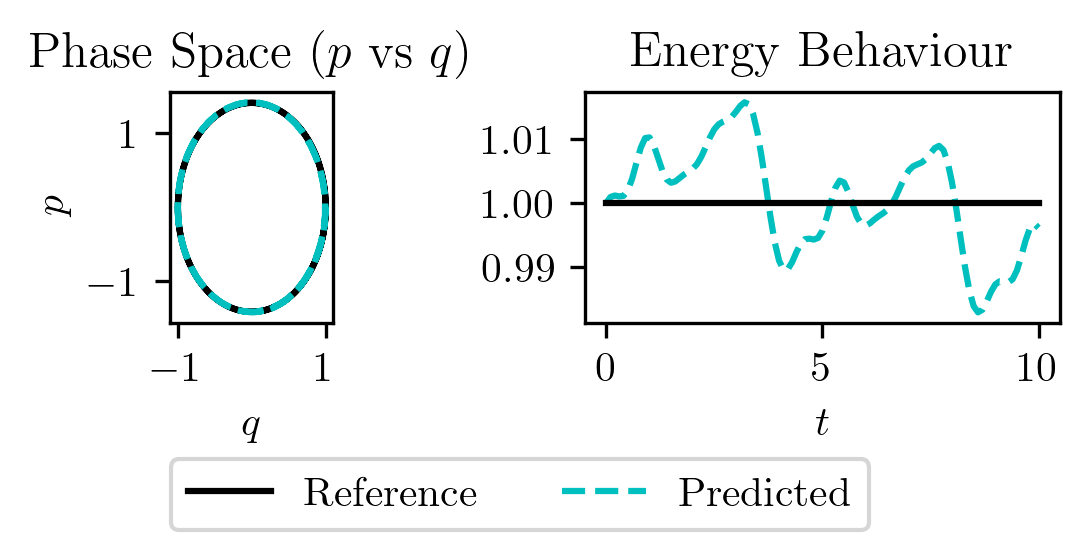

Selected initial condition :  [1. 0.]


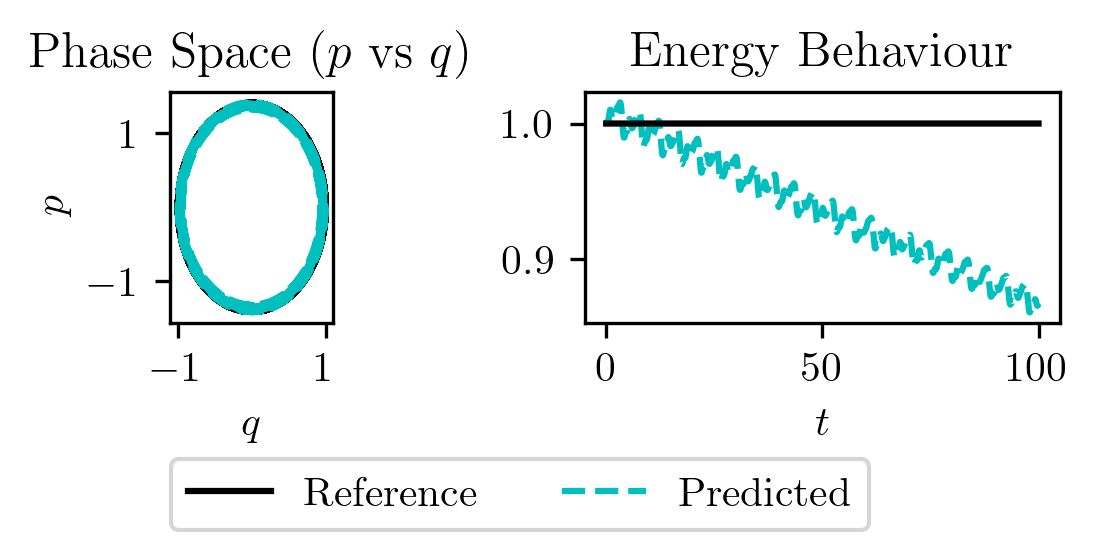

In [18]:
generate_plots(ic,model_nonsymplectic,T=10,label="resnet")
generate_plots(ic,model_nonsymplectic,T=100,label="resnet")